# Dog breed image classification
In this notebook is trained and deployed a endpoit a model that is trained with dog images to identify their breed.

In [3]:
# smdebug is a library that allows you to easily debug, visualize, and save tensors and parameters from TensorFlow, Keras, PyTorch, and MXNet.
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [4]:
# sageMaker is a library that allows you to easily train and deploy machine learning models on Amazon SageMaker.
# boto3 is the AWS SDK for Python. It enables Python developers to create, configure, and manage AWS services, such as EC2 and S3.
# os provides a portable way of using operating system dependent functionality.
import sagemaker
import boto3
import os

In [5]:
#sageamker_datawrangler is a library that allows you to easily prepare data for machine learning.
try:
    import sagemaker_datawrangler
except ImportError:
    !pip install --upgrade sagemaker-datawrangler
    import sagemaker_datawrangler

## Dataset
The dataset contains over 8000 images of dogs, each labeled with the corresponding breed. This dataset is commonly used in machine learning projects related to image classification or object recognition, particularly those focused on dogs. It is often used as a benchmark dataset for evaluating the performance of various machine learning algorithms and models.

In [8]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip > /dev/null

--2023-05-06 16:58:22--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.194.96
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.194.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.1’

dogImages.zip.1     100%[===================>]   1.05G  49.0MB/s    in 23s     

2023-05-06 16:58:55 (46.4 MB/s) - ‘dogImages.zip.1’ saved [1132023110/1132023110]

unzip:  cannot find or open dogImages., dogImages..zip or dogImages..ZIP.


In [6]:
# setting the default bucket and role for this session

bucket= 'udacityproject3'
print("Default Bucket: {}".format(bucket))

region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: udacityproject3
AWS Region: us-east-1
RoleArn: arn:aws:iam::237845067016:role/service-role/AmazonSageMaker-ExecutionRole-20230402T181968


In [15]:
#Fetch and upload the data to AWS S3

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/train/; 
!aws s3 sync ./dogImages/test s3://${DEFAULT_S3_BUCKET}/test/;
!aws s3 sync ./dogImages/valid s3://${DEFAULT_S3_BUCKET}/valid/;

upload: dogImages/train/001.Affenpinscher/Affenpinscher_00002.jpg to s3://udacityproject3/train/001.Affenpinscher/Affenpinscher_00002.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00004.jpg to s3://udacityproject3/train/001.Affenpinscher/Affenpinscher_00004.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg to s3://udacityproject3/train/001.Affenpinscher/Affenpinscher_00001.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00010.jpg to s3://udacityproject3/train/001.Affenpinscher/Affenpinscher_00010.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00007.jpg to s3://udacityproject3/train/001.Affenpinscher/Affenpinscher_00007.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00008.jpg to s3://udacityproject3/train/001.Affenpinscher/Affenpinscher_00008.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00011.jpg to s3://udacityproject3/train/001.Affenpinscher/Affenpinscher_00011.jpg
upload: dogImages/train/001.Affenp

## Hyperparameter Tuning

In [8]:
from sagemaker.tuner import (IntegerParameter, 
                            CategoricalParameter, 
                            ContinuousParameter,
                            HyperparameterTuner)
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.session import Session

In [9]:
#Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    'lr': ContinuousParameter(0.001, 0.1), # learning rate is the parameter that controls how quickly the model is adapted to the problem
    'batch_size': CategoricalParameter([32,64,128]),  # batch size is the number of training examples utilized in one iteration
    'epochs': IntegerParameter(2, 3) # number of epochs is the number of complete passes through the training dataset
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [10]:
#Create estimators for your HPs
estimator = PyTorch(entry_point = 'hpo.py',
                                    base_job_name = 'breedClassification',
                                    role = role,
                                    instance_count = 1,
                                    instance_type = 'ml.m5.2xlarge', 
                                    py_version = 'py36',
                                    framework_version = '1.8')

tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs = 3,
                            max_parallel_jobs = 3,
                            objective_type = objective_type)

In [ ]:
# Fit the estimator
estimator.fit({'train':'s3://udacityproject3/dogImages'}, wait=True) 

2023-05-07 12:12:03 Starting - Starting the training job...
2023-05-07 12:12:18 Starting - Preparing the instances for training...
2023-05-07 12:13:10 Downloading - Downloading input data......
2023-05-07 12:14:10 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-05-07 12:14:25,598 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-05-07 12:14:25,601 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-05-07 12:14:25,609 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-05-07 12:14:25,611 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-05-07 12:14:25,792 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-05-07 12:14:25,806 sagemaker-training-toolkit INFO     No

In [12]:
# Fit your HP Tuner
# input data is the location of the training data
tuner.fit({'train':'s3://udacityproject3/dogImages'}, wait=True) 

.......................................................................................................!


# Geting the best estimators and the best HPs

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
# Using the best hyperparameters, create and finetune a new model
# Setting up debugging and profiling rules and hooks

from sagemaker.debugger import Rule, rule_configs, ProfilerRule, DebuggerHookConfig, CollectionConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
        ]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, 
                                                       framework_profile_params = FrameworkProfile(num_steps=10))

collection_config = [CollectionConfig(name="CrossEntropyLoss_output_0", 
                                      parameters={"include_regex": "CrossEntropyLoss_output_0",
                                                                   "train.save_interval": "10",
                                                                   "eval.save_interval": "1"
                                                 }
                                     )
                    ]

debugger_config = DebuggerHookConfig(collection_configs = collection_config)

In [ ]:
best_estimator = tuner.best_estimator()
best_estimator.hyperparameters()


2023-05-14 21:02:19 Starting - Preparing the instances for training
2023-05-14 21:02:19 Downloading - Downloading input data
2023-05-14 21:02:19 Training - Training image download completed. Training in progress.
2023-05-14 21:02:19 Uploading - Uploading generated training model
2023-05-14 21:02:19 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'epochs': '2',
 'lr': '0.004541472976088734',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"breedClassification-2023-05-14-20-55-14-334"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-237845067016/breedClassification-2023-05-14-20-55-14-334/source/sourcedir.tar.gz"'}

In [2]:
best_hyperparameters = {'batch_size': 128,'epochs': 2, 'lr': 0.004541472976088734}

In [3]:
print(best_hyperparameters)
# Create a new estimator with the best hyperparameters and fit the model
estimator = PyTorch(entry_point = 'train_model.py',
                                    role = role,
                                    instance_count=4,
                                    instance_type = 'ml.m5.2xlarge',
                                    py_version = 'py36',
                                    framework_version = '1.6',
                                    hyperparameters = best_hyperparameters,
                                    profiler_config = profiler_config, 
                                    debugger_hook_config = debugger_config, 
                                    rules = rules ) 

{'batch_size': 128, 'epochs': 2, 'lr': 0.004541472976088734}


In [39]:
# Fit the estimator with the best hyperparameters to the data
estimator.fit({'train':'s3://udacityproject3/dogImages'}, wait=True)

2023-05-14 21:44:37 Starting - Starting the training job...
2023-05-14 21:45:02 Starting - Preparing the instances for trainingVanishingGradient: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2023-05-14 21:46:43 Downloading - Downloading input data......
2023-05-14 21:47:43 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-05-14 21:47:31,554 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-05-14 21:47:31,556 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-05-14 21:47:31,567 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-05-14 21:47:31,569 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-05-14 21:47:31,733 sagemaker-training-toolkit INFO     No GPUs det

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Model Deploying

In [61]:
# in this section first we will create a PyTorchModel object from the estimator that we trained in the previous section
# then we will deploy the model to an endpoint

# IdentitySerializer and JSONDeserializer are used to serialize and deserialize the data sent to and from the endpoint
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

# Predictor class is used to create a predictor object that will be used to send data to the endpoint
from sagemaker.predictor import Predictor

# this class ImgPredictor is a subclass created from the Predictor class and is used to send image data to the endpoint
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super(ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )

# create a PyTorchModel object from the estimator that we trained in the previous section        
pytorch_model = PyTorchModel(model_data = model_location,
                             role = role,
                             entry_point= "deploy_endpoint.py",
                             py_version = "py36",
                             framework_version = "1.6",
                             predictor_cls = ImgPredictor
                            )
# deploy the model to an endpoint
predictor = pytorch_model.deploy(initial_instance_count = 1, instance_type = "ml.m5.2xlarge")

-----!

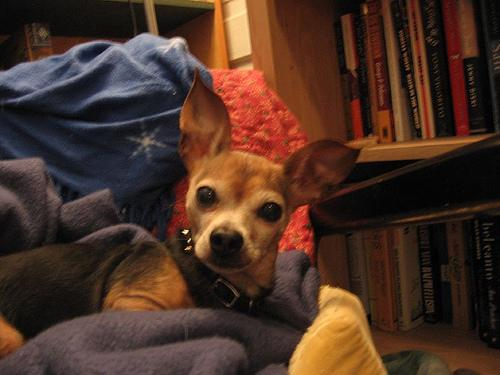

Predicted Breed: [48] 




In [68]:
from PIL import Image
import io
import os
import numpy as np

test_image_path = os.path.join("./dogImages/test/048.Chihuahua/", "Chihuahua_03411.jpg")
with open(test_image_path, "rb") as f:
    image_bytes = f.read()
    predicted_breed = np.argmax(predictor.predict(image_bytes), 1) + 1
    print(f"Predicted Breed: {predicted_breed} \n\n")
    display(Image.open(io.BytesIO(image_bytes)))

In [ ]:
predictor.delete_endpoint()

# Image Classification using AWS SageMaker

Use AWS Sagemaker to train a pretrained model that can perform image classification by using the Sagemaker profiling, debugger, hyperparameter tuning and other good ML engineering practices. This can be done on either the provided dog breed classication data set or one of your choice.

## Project Set Up and Installation
Enter AWS through the gateway in the course and open SageMaker Studio. 
Download the starter files.
Download/Make the dataset available. 

## Dataset
The provided dataset is the dogbreed classification dataset which can be found in the classroom.
The project is designed to be dataset independent so if there is a dataset that is more interesting or relevant to your work, you are welcome to use it to complete the project.

### Access
Upload the data to an S3 bucket through the AWS Gateway so that SageMaker has access to the data. 

## Hyperparameter Tuning
### What kind of model did you choose for this experiment and why? 

I chose ResNet50 as a pretrained model to recognize images. One of the main advantages of the model is the capability to perform in diferent datasets and image sizes.

### Give an overview of the types of parameters and their ranges used for the hyperparameter search

It was performed a grid search for the learning rate, varying from 0.001 to 0.1, batch size, with values of 32,64 and 128 and number of epochs, being 2 or 3.

Remember that your README should include:
### A screenshot of completed training jobs

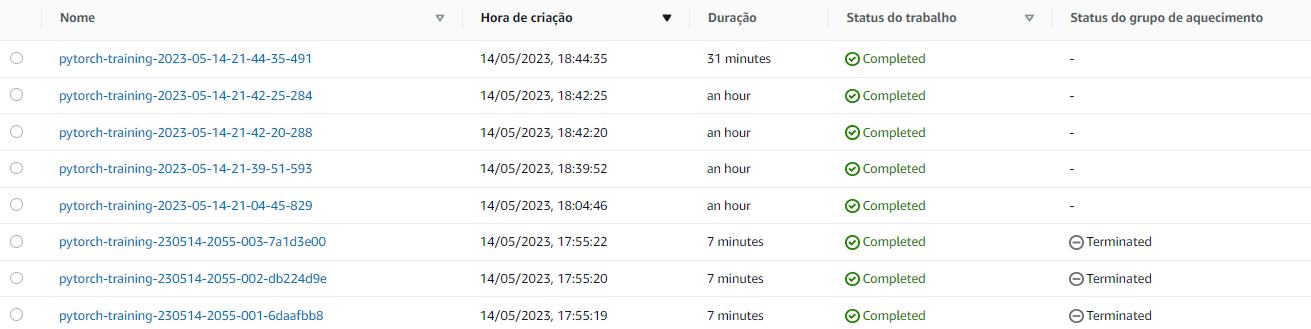

### Logs metrics during the training process
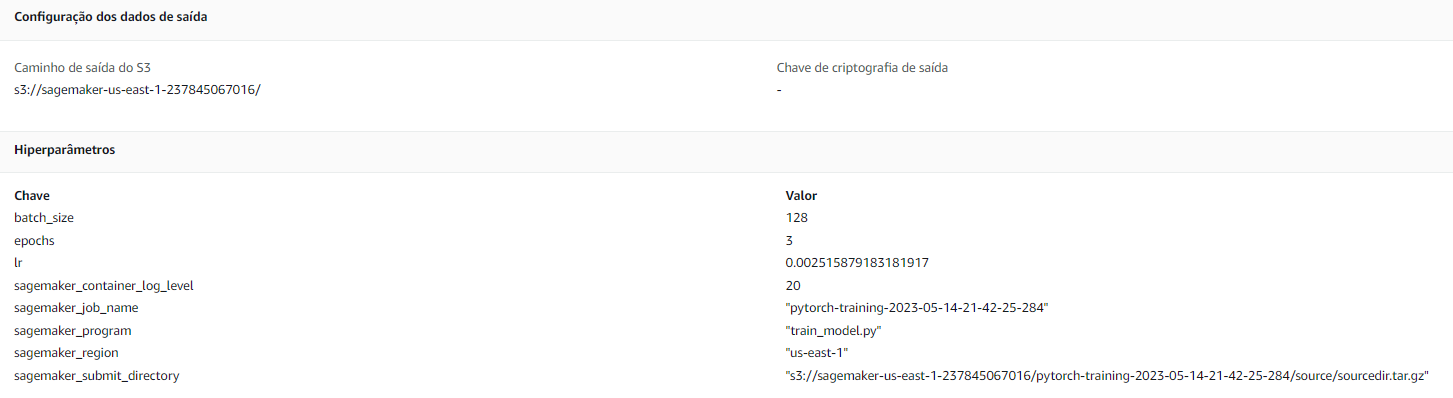

### Tune at least two hyperparameters
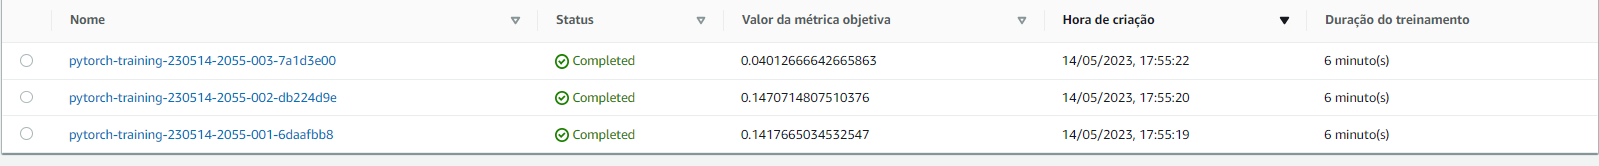

### Retrieve the best best hyperparameters from all your training jobs
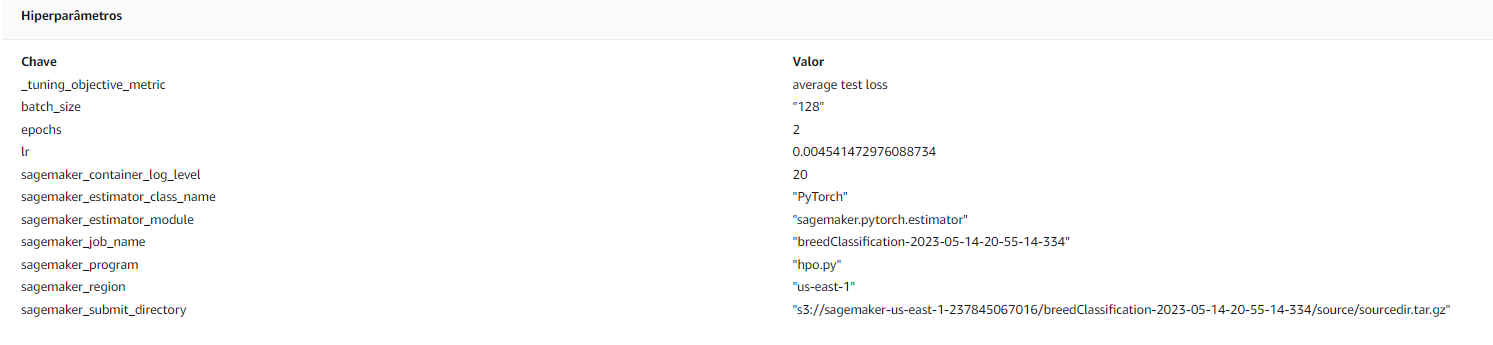

## Debugging and Profiling
**TODO**: Give an overview of how you performed model debugging and profiling in Sagemaker

### Results
**TODO**: What are the results/insights did you get by profiling/debugging your model?

**TODO** Remember to provide the profiler html/pdf file in your submission.

## Model Deployment
**TODO**: Give an overview of the deployed model and instructions on how to query the endpoint with a sample input.

**TODO** Remember to provide a screenshot of the deployed active endpoint in Sagemaker.